### 1. Importing the libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
data = pd.read_csv('Desktop/Online Retail.csv', encoding = 'unicode_escape')

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
data.Description.fillna(' ')
data = data[pd.notnull(data.CustomerID)]

In [8]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
data.Quantity = data.Quantity.apply(lambda x : 0 if x < 0 else x)

In [10]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

In [11]:
data['Amount'] = data['Quantity'] * data['UnitPrice']

In [12]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
data.InvoiceDate.max()

Timestamp('2011-12-10 17:19:00')

In [14]:
'''
Recency is calulated as diffrence between Recent date and Last Invoice date (last purchase) 
Frequency is calculated as Unique values of Invoice Number (Bills)
Monetary value is calucated from Amount spent by customer
'''
import datetime as dt # for calculating recency 

c_date = dt.datetime(2011, 12, 11) # as maximum date in dataset is 10/12/2011 so we will set our current date as 11/12/2011

# Now we will create RFM modeling score for each customer

rfm_data = data.groupby('CustomerID').agg({
                        'InvoiceDate' : lambda x : (c_date - x.max()).days, 
                        'InvoiceNo' : lambda x : x.count(), 
                        'Amount' : lambda x : sum(x) })

# Now we will rename columns name to Recency, Frequency and Monetory
rfm_data.rename(columns = {
                        'InvoiceDate' : 'Recency', 
                        'InvoiceNo' : 'Frequency', 
                        'Amount' : 'Monetary' }, inplace = True)

# Now we will use resetindex to make sure that indexes are continuos.
rfm_data.reset_index(inplace = True)

In [15]:
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,77183.60
1,12347.0,40,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40


In [16]:
rfm_data.describe()

,CustomerID,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,100.987420,93.053294,2038.290920
std,1722.390705,113.931649,232.471608,8956.019171
min,12346.000000,0.000000,1.000000,0.000000
25%,13812.750000,20.000000,17.000000,303.602500
50%,15300.500000,57.000000,42.000000,665.315000
75%,16778.250000,152.000000,102.000000,1652.790000
max,18287.000000,697.000000,7983.000000,280206.020000


In [19]:
# Now we will divide customers into 4 segments on basis of their rfm_score for which we will create quantiles

quantiles = rfm_data.quantile(q = [0.25, 0.5, 0.75 ]) #using quantile function to get value of quantiles
quantiles = quantiles.to_dict() # coverting into dictionary for easier mapping 
quantiles

{'CustomerID': {0.25: 13812.75, 0.5: 15300.5, 0.75: 16778.25},
 'Recency': {0.25: 20.0, 0.5: 57.0, 0.75: 152.0},
 'Frequency': {0.25: 17.0, 0.5: 42.0, 0.75: 102.0},
 'Monetary': {0.25: 303.6025, 0.5: 665.3150000000003, 0.75: 1652.790000000002}}

In [20]:
# Now we will assign  R and FM score to each category and customers
def R_score(val, param):
    if val <= quantiles[param][0.25]:   return 1
    elif val <= quantiles[param][0.50]: return 2
    elif val <= quantiles[param][0.75]: return 3
    else: return 4

def FM_score(val, param):
    if val <= quantiles[param][0.25]:   return 4
    elif val <= quantiles[param][0.50]: return 3
    elif val <= quantiles[param][0.75]: return 2
    else: return 1

# here we have used same ranking method for Frequency and Monetary because higher their value higher they are loyal to company
# while in case of RECENCY lower the value of recency higher they are loyal to company.  

#in short the lowest recency, highest frequency and monetary amounts are our best customers.

In [21]:
rfm_data['R'] = rfm_data['Recency'].apply(lambda x : R_score(x, 'Recency')) # giving R score 
rfm_data['F'] = rfm_data['Frequency'].apply(lambda x : FM_score(x, 'Frequency')) # giving F score
rfm_data['M'] = rfm_data['Monetary'].apply(lambda x : FM_score(x, 'Monetary')) # giving M score

In [22]:
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346.0,326,2,77183.60,4,4,1
1,12347.0,40,182,4310.00,2,1,1
2,12348.0,76,31,1797.24,3,3,1
3,12349.0,19,73,1757.55,1,2,1
4,12350.0,311,17,334.40,4,4,3


In [23]:
rfm_data['Group'] = rfm_data.R.map(str) + rfm_data.F.map(str) + rfm_data.M.map(str) 

# here we will make a new column of score which will store the score of group by adding RFM scores
rfm_data['Score'] = rfm_data[['R', 'F', 'M']].sum(axis = 1)

rfm_data.head(7)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score
0,12346.0,326,2,77183.60,4,4,1,441,9
1,12347.0,40,182,4310.00,2,1,1,211,4
2,12348.0,76,31,1797.24,3,3,1,331,7
3,12349.0,19,73,1757.55,1,2,1,121,4
4,12350.0,311,17,334.40,4,4,3,443,11
5,12352.0,73,95,2506.04,3,2,1,321,6
6,12353.0,205,4,89.00,4,4,4,444,12


In [24]:
Membership = ['Platinum', 'Gold', 'Silver', 'Bronze']  # assigning membership level for customers

Score_cuts = pd.qcut(rfm_data.Score, q = 4, labels = Membership) # get the score using pandas.qcut method

rfm_data['Membership'] = Score_cuts.values # assign the score cuts values to new column Membership

rfm_data.head(10) # pritns the head of dataset

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership
0,12346.0,326,2,77183.60,4,4,1,441,9,Silver
1,12347.0,40,182,4310.00,2,1,1,211,4,Platinum
2,12348.0,76,31,1797.24,3,3,1,331,7,Gold
3,12349.0,19,73,1757.55,1,2,1,121,4,Platinum
4,12350.0,311,17,334.40,4,4,3,443,11,Bronze
5,12352.0,73,95,2506.04,3,2,1,321,6,Gold
6,12353.0,205,4,89.00,4,4,4,444,12,Bronze
7,12354.0,233,58,1079.40,4,2,2,422,8,Gold
8,12355.0,96,13,459.40,3,4,3,343,10,Silver
9,12356.0,23,59,2811.43,2,2,1,221,5,Platinum


In [31]:
# now we will perform feature scaling on the datset, from the distribution plot which we plotted earlier we saw that our
# data is  right skewed and we need to perform suitable normalization technique to scale our data accordingly
# so we will use LOG TRANSFORM to scale our data. 

import math

# because log(0) in nan so we will hande it explicitly
# training dataset which only contain 3 features of RFM for finding optimal value of K in Kmeans
X_train = rfm_data.iloc[:, [1, 2, 3]]

# now we will apply changes to the X_training dataset instead of the original RFM dataset
X_train.Recency = rfm_data.Recency.apply(lambda x : 0 if x == 0 else round(math.log(x), 3)) 
X_train.Frequency = rfm_data.Frequency.apply(lambda x : 0 if x == 0 else round(math.log(x), 3))
X_train.Monetary = rfm_data.Monetary.apply(lambda x : 0 if x == 0 else round(math.log(x), 3))

<AxesSubplot:xlabel='Recency', ylabel='Density'>

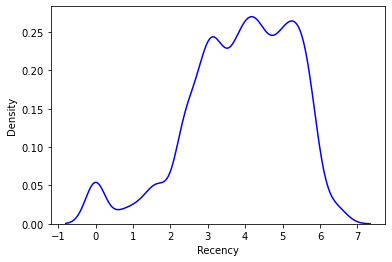

In [33]:
sns.distplot(X_train['Recency'], hist = False, color = 'b')

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

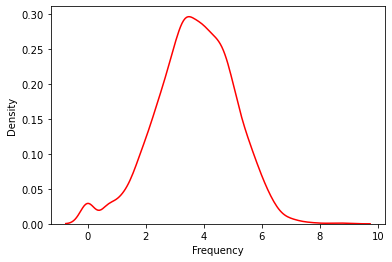

In [34]:
sns.distplot(X_train['Frequency'], hist = False, color = 'r')

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

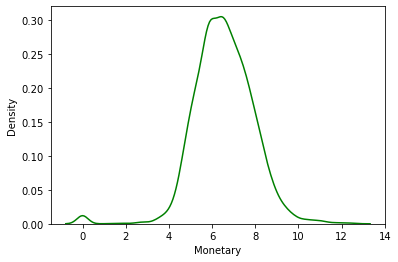

In [35]:
sns.distplot(X_train['Monetary'], hist = False, color = 'g')

In [36]:
# we will apply standard scaler to bring the dimension of X_train in same range
from sklearn.preprocessing import StandardScaler as scaler

sc = scaler() # create instance of Standardscaler

Scaled_Data = sc.fit_transform(X_train) # applying transformation to X_train

Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_data.index, columns = X_train.columns) # changing into dataframe again

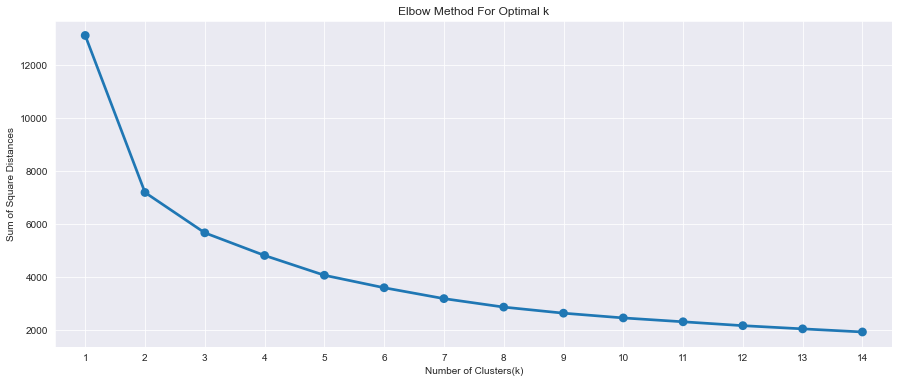

In [37]:
# Now we will find the optimal value of k in Kmeans clustering using elbow method

from sklearn.cluster import KMeans

square_dist = [] # for storing square_distance after using Kmeans model
itr = [] # for storing iteration count 

for i in range(1, 15) : 
    model = KMeans(n_clusters = i, max_iter = 1000)
    model.fit(Scaled_Data)
    square_dist.append(model.inertia_)
    itr.append(i)

# now we will plot the graphical representaion of square distance and iterations
sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))
sns.pointplot(itr, square_dist, col = 'b')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# After plotting we infer that there is sharp decrease / elbow formed when n_clusters are = 3 so we will
# create our final model using number of clusters equals to 3

In [38]:
# Now we will build the model using K Means clustering. 
model = KMeans(n_clusters = 3, max_iter = 1000) # explicitly passing number of iterations

# fitting scaled dataset into our Kmeans Model
model.fit(Scaled_Data)

# adding cluster variable to the RFM dataset to check membership level of customer. 
rfm_data['Cluster'] = model.labels_ # labels_ returns the cluster of each datapoint (similar to y_pred).

rfm_data.head(5)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership,Cluster
0,12346.0,326,2,77183.60,4,4,1,441,9,Silver,2
1,12347.0,40,182,4310.00,2,1,1,211,4,Platinum,1
2,12348.0,76,31,1797.24,3,3,1,331,7,Gold,2
3,12349.0,19,73,1757.55,1,2,1,121,4,Platinum,1
4,12350.0,311,17,334.40,4,4,3,443,11,Bronze,0


In [39]:
# Now we will plot the ouput clusters values with corresponding RFM values
# We will assign the colour RED -> platinum class cluster(0), BLUE -> gold and silver cluster(1) , GREEN -> Bronze cluster(2)

rfm_data['Colour'] = rfm_data['Cluster'].apply(lambda x : 'Red' if x == 0 else ('Green' if x == 2 else 'Blue'))

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

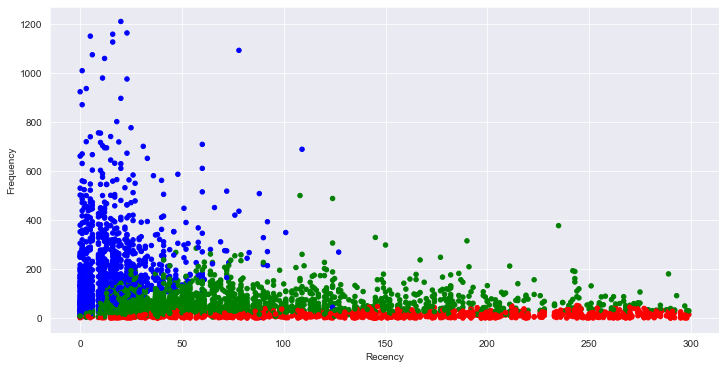

In [56]:
# Now we will plot the colour value against RFM values which tells us about the cluster in which customer belongs to

dist = rfm_data[rfm_data.Frequency < 1250 ][rfm_data.Recency < 300] # as most of the frequency value is less than 2000 

dist.plot(x = 'Recency', y = 'Frequency', kind = 'scatter', c = dist['Colour'], figsize = (12, 6))

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

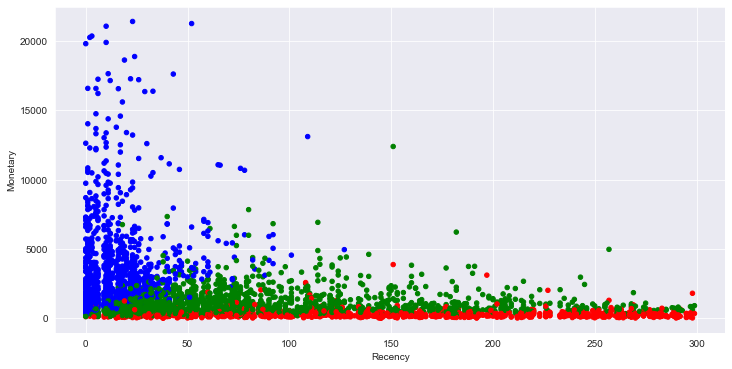

In [53]:
dist = rfm_data[rfm_data.Monetary < 25000 ][rfm_data.Recency < 300] # as most of the frequency value is less than 2000 

dist.plot(x = 'Recency', y = 'Monetary', kind = 'scatter', c = dist['Colour'], figsize = (12, 6))

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

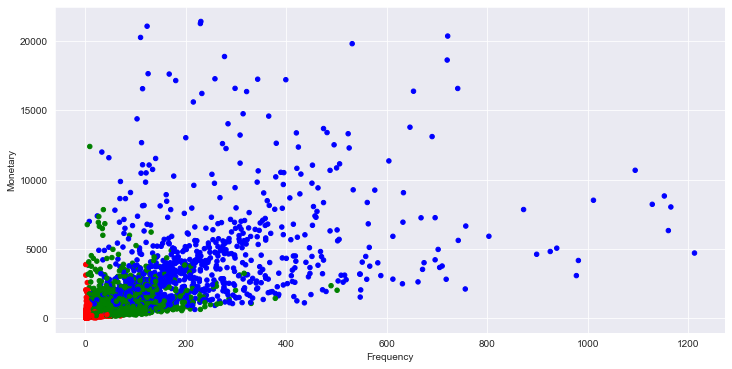

In [54]:
dist = rfm_data[rfm_data.Monetary < 25000 ][rfm_data.Frequency < 1250] # as most of the frequency value is less than 2000 

dist.plot(x = 'Frequency', y = 'Monetary', kind = 'scatter', c = dist['Colour'], figsize = (12, 6))

In [57]:
def rfm_values(data):

    data_new = data.groupby(['Membership']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return data_new

In [59]:
rfm_values(rfm_data)

Recency Frequency Monetary      
              mean      mean     mean count
Membership                                 
Platinum      24.0     232.0   5218.0  1277
Gold          68.0      59.0   1229.0  1314
Silver       138.0      25.0    484.0  1019
Bronze       237.0      11.0    185.0   762